In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020158,2025-10-29T00:15:00,St. Louis Blues,Detroit Red Wings,0.5611,0.4040,0.7829,2,5,False,True,False
1,2025020076,2025-10-18T17:00:00,Buffalo Sabres,Florida Panthers,0.5602,0.4793,0.7733,3,0,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          276      0.5362 0.2545   0.7029 0.5189   0.5217
Totals (Over/Under)  276      0.4964 0.2508   0.6947 0.5251   0.5254
Asian Handicap       276      0.7681 0.1814   0.5502 0.5305   0.7645


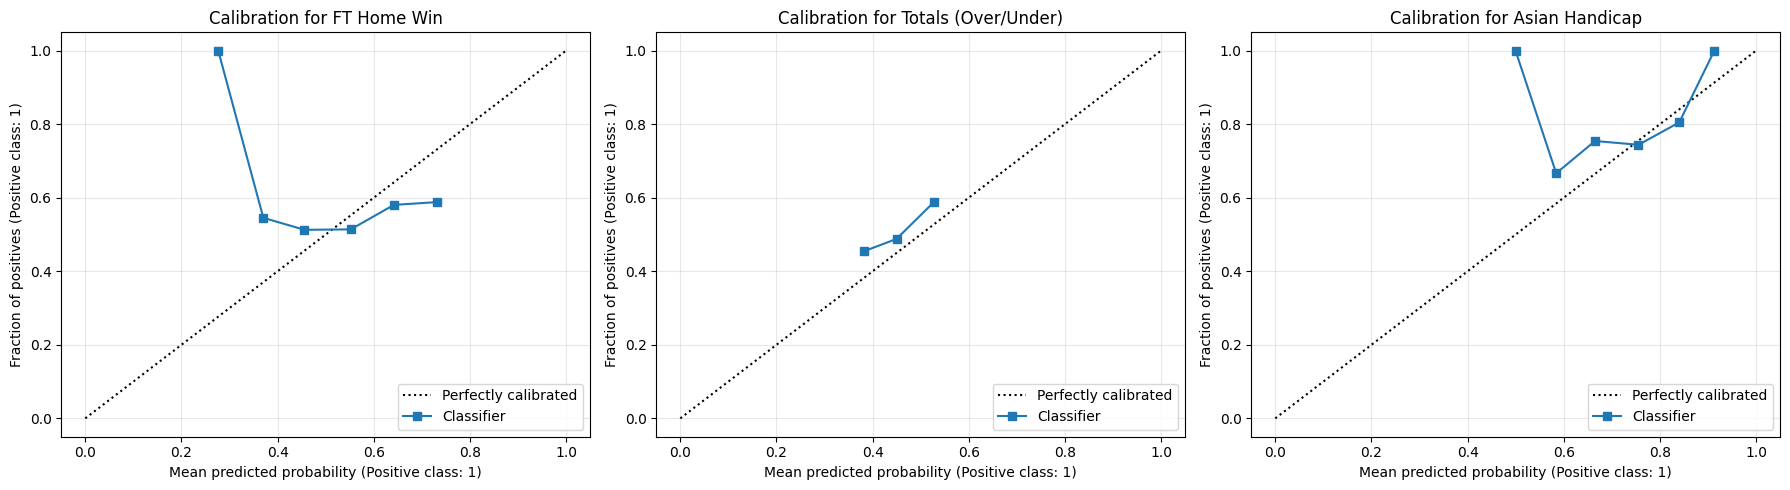

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=10)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          136      0.5441 0.2486   0.6897 0.5620   0.5221
Totals (Over/Under)  136      0.5221 0.2512   0.6955 0.5452   0.4926
Asian Handicap       136      0.7794 0.1783   0.5409 0.5135   0.7721


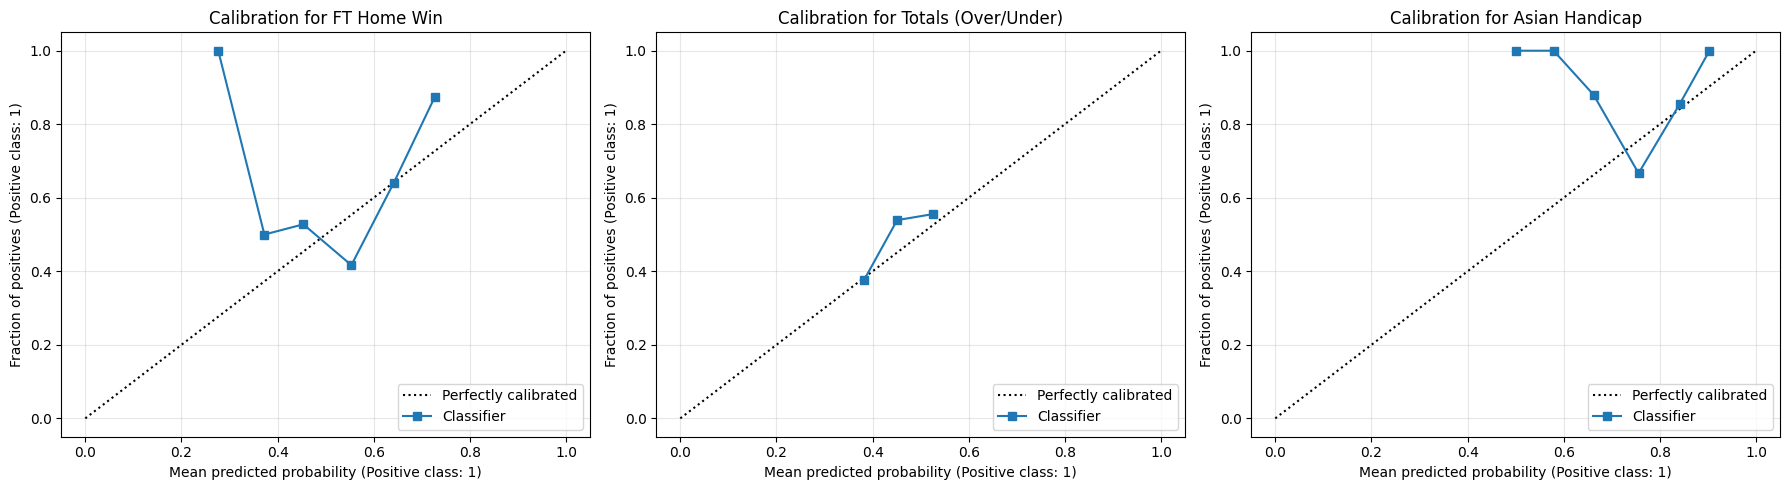

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=10)

## NBA

In [9]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500244,2025-11-18T00:30:00,Miami Heat,New York Knicks,0.6021,0.4706,0.7951,115,113,True,True,True
1,0022500248,2025-11-18T02:00:00,Denver Nuggets,Chicago Bulls,0.7210,0.8174,0.8707,127,130,False,True,True


=== Evaluation Summary ===
                     n  prevalence  brier  logloss    auc  acc@0.5
metric                                                            
FT Home Win          8      0.7500 0.1579   0.4840 0.7500   0.7500
Totals (Over/Under)  8      0.5000 0.2842   0.7693 0.5000   0.3750
Asian Handicap       8      0.8750 0.0343   0.1891 1.0000   1.0000


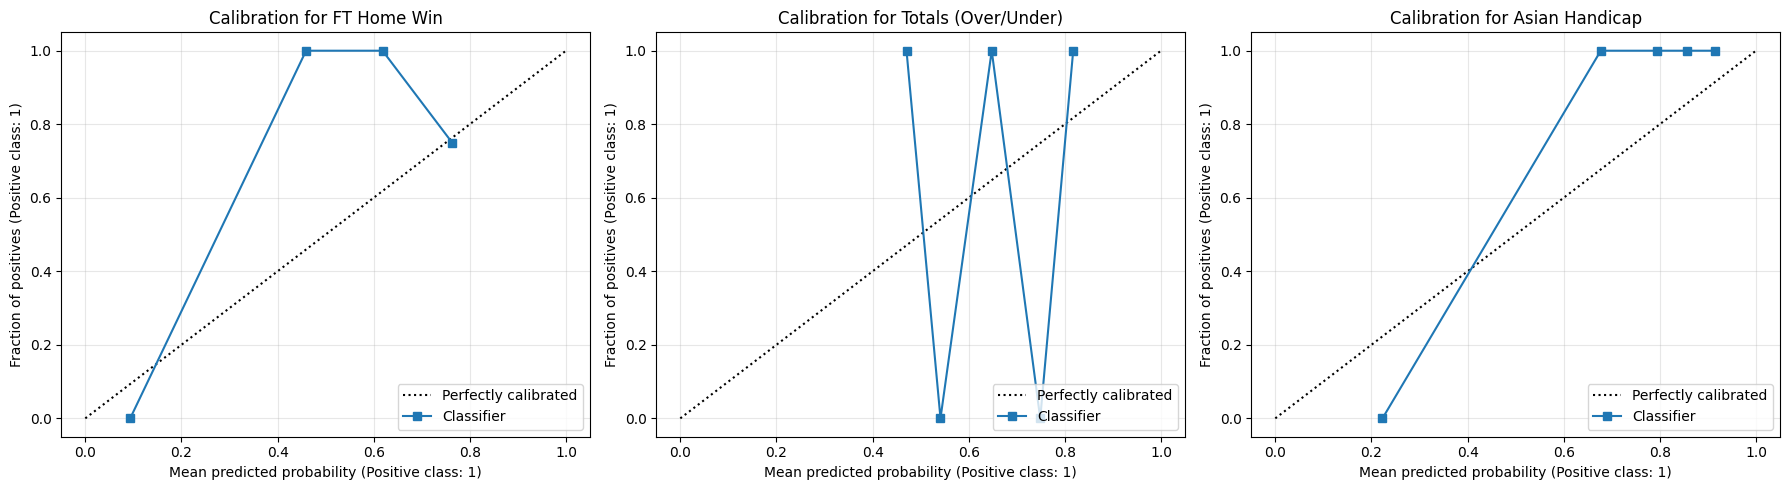

In [10]:
_ = u.evaluate_calibration(df=df, n_bins=10)